In [1]:
import seaborn as sn
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [2]:
Training_Data = pd.ExcelFile("Training Data.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[0])
label_data = Label_Data.parse(Label_Data.sheet_names[0])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'ATP', 'INDEX MEDU', 'MATCH DEMOS OLD', 'INDEX AGE'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['HYP'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','MATCH BASC2', 'INDEX ATP', 'INDEX HYP', 'ATP'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

(148, 300)
(148, 1)


In [3]:
twin_data = Training_Data.parse(Training_Data.sheet_names[2])
label_twin_data = Label_Data.parse(Label_Data.sheet_names[2])
twin_data_features = twin_data.loc[:, twin_data.columns]
twin_data_features = twin_data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'ATP', 'INDEX MEDU', 'MATCH DEMOS OLD', 'INDEX AGE'], axis=1)
twin_data_features = twin_data_features.dropna()
twin_data_features = twin_data_features.drop(['HYP'], axis=1)
twin_labels = label_twin_data.loc[:, label_twin_data.columns]
twin_labels = twin_labels.drop(['ROI','MATCH BASC2', 'INDEX ATP', 'INDEX HYP', 'ATP'], axis=1)
twin_labels = twin_labels.dropna()
print(twin_data_features.shape)
print(twin_labels.shape)

#Grab every other row so as to not get both twins
twin_data_features = twin_data_features.iloc[::2, :]
twin_labels = twin_labels.iloc[::2, :]
print(twin_data_features.shape)
print(twin_labels.shape)

(155, 300)
(155, 1)
(78, 300)
(78, 1)


In [4]:
interpolated_data = Training_Data.parse(Training_Data.sheet_names[4])
interpolated_data_features = interpolated_data.loc[:, interpolated_data.columns]
interpolated_data_features = interpolated_data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'ATP', 'ATP Label', 'HYP Label', 'INDEX MEDU'], axis=1)
interpolated_data_features = interpolated_data_features.dropna()
interpolated_data_features = interpolated_data_features.drop(['HYP'], axis=1)

interpolated_label_data = Label_Data.parse(Label_Data.sheet_names[4])
interpolated_labels = interpolated_label_data.loc[:, interpolated_label_data.columns]
interpolated_labels = interpolated_labels.drop(['ROI','ATP'], axis=1)
interpolated_labels = interpolated_labels.dropna()

print(interpolated_data_features.shape)
print(interpolated_labels.shape)
print(type(interpolated_data_features))

(34, 300)
(34, 1)
<class 'pandas.core.frame.DataFrame'>


In [5]:
data_1y = [data_features, twin_data_features]
labels_1y = [labels, twin_labels]

data_features = pd.concat(data_1y)
labels = pd.concat(labels_1y)

print(data_features.shape)
print(labels.shape)

(226, 300)
(226, 1)


In [6]:
skf = StratifiedKFold(n_splits=8)
skf.get_n_splits(data_features, labels)
print(skf)

training_indices_X = []
testing_indices_X = []
training_indices_Y = []
testing_indices_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features.iloc[train_index], data_features.iloc[test_index]
    Y_train, Y_test = labels.iloc[train_index], labels.iloc[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2) 
    X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    print(X_train_res.shape)
    training_indices_X.append(X_train_res)
    testing_indices_X.append(X_test)
    training_indices_Y.append(Y_train_res)
    testing_indices_Y.append(Y_test)


StratifiedKFold(n_splits=8, random_state=None, shuffle=False)
(354, 300)
(354, 300)
(354, 300)
(356, 300)
(356, 300)
(356, 300)
(356, 300)
(356, 300)


In [7]:
training_indices_X[0].head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,SEX,Gestational Age,Maternal Education MEDU,Age at MRI 1
0,-0.260603,-0.074447,0.123098,0.110227,-0.277062,0.287692,0.206996,-0.073593,0.111419,-0.033235,...,0.328442,0.554984,0.467020,0.113749,0.363633,0.324901,1.0,0.666667,8.0,1.073973
1,-0.116665,-0.053437,0.092206,0.146712,-0.213654,0.319648,0.178145,-0.276711,0.243473,0.304333,...,0.256893,0.222129,0.415340,0.252474,0.669453,0.370307,1.0,0.666667,8.0,1.052055
2,0.005308,-0.060916,0.193935,0.092845,-0.086244,0.312178,0.034798,-0.244214,0.114453,0.203349,...,0.236034,0.402563,0.560475,0.532426,0.358366,0.435519,0.0,0.916667,15.0,0.978082
3,-0.162115,-0.159799,0.186191,0.125560,-0.179891,0.420484,0.087587,-0.073629,0.276718,0.064749,...,0.190745,0.421105,0.258039,0.335113,0.438831,0.098697,1.0,0.750000,16.0,1.054795
4,-0.101819,-0.008209,0.373775,0.071498,-0.014684,0.598363,0.292339,-0.139739,0.062950,-0.127031,...,0.260455,0.132798,0.142365,0.470704,0.228815,0.335065,1.0,0.750000,16.0,1.104110


In [8]:
for x in training_indices_X:
    print(x.shape)
    
#Figure out how to loop this later. Wasn't working for the following code:
#for x in training_indices_X:
#    x = pd.concat([x,interpolated_data_features])

training_indices_X[0] = pd.concat([training_indices_X[0],interpolated_data_features])
training_indices_X[1] = pd.concat([training_indices_X[1],interpolated_data_features])
training_indices_X[2] = pd.concat([training_indices_X[2],interpolated_data_features])
training_indices_X[3] = pd.concat([training_indices_X[3],interpolated_data_features])
training_indices_X[4] = pd.concat([training_indices_X[4],interpolated_data_features])
training_indices_X[5] = pd.concat([training_indices_X[5],interpolated_data_features])
training_indices_X[6] = pd.concat([training_indices_X[6],interpolated_data_features])
training_indices_X[7] = pd.concat([training_indices_X[7],interpolated_data_features])

print('----------')
for x in training_indices_X:
    print(x.shape)
    
print('Label shapes')
    
for y in training_indices_Y:
    print(y.shape)

training_indices_Y[0] = pd.concat([training_indices_Y[0],interpolated_labels])
training_indices_Y[1] = pd.concat([training_indices_Y[1],interpolated_labels])
training_indices_Y[2] = pd.concat([training_indices_Y[2],interpolated_labels])
training_indices_Y[3] = pd.concat([training_indices_Y[3],interpolated_labels])
training_indices_Y[4] = pd.concat([training_indices_Y[4],interpolated_labels])
training_indices_Y[5] = pd.concat([training_indices_Y[5],interpolated_labels])
training_indices_Y[6] = pd.concat([training_indices_Y[6],interpolated_labels])
training_indices_Y[7] = pd.concat([training_indices_Y[7],interpolated_labels])

print('----------')
for y in training_indices_Y:
    print(y.shape)


(354, 300)
(354, 300)
(354, 300)
(356, 300)
(356, 300)
(356, 300)
(356, 300)
(356, 300)
----------
(388, 300)
(388, 300)
(388, 300)
(390, 300)
(390, 300)
(390, 300)
(390, 300)
(390, 300)
Label shapes
(354, 1)
(354, 1)
(354, 1)
(356, 1)
(356, 1)
(356, 1)
(356, 1)
(356, 1)
----------
(388, 1)
(388, 1)
(388, 1)
(390, 1)
(390, 1)
(390, 1)
(390, 1)
(390, 1)


In [9]:
#training_indices_X[0] #8 Folds so 0 -> 7 Data type is a DataFrame currently.
training_fold_X_0 = training_indices_X[0].to_numpy()
training_fold_X_1 = training_indices_X[1].to_numpy()
training_fold_X_2 = training_indices_X[2].to_numpy()
training_fold_X_3 = training_indices_X[3].to_numpy()
training_fold_X_4 = training_indices_X[4].to_numpy()
training_fold_X_5 = training_indices_X[5].to_numpy()
training_fold_X_6 = training_indices_X[6].to_numpy()
training_fold_X_7 = training_indices_X[7].to_numpy()

training_fold_Y_0 = training_indices_Y[0].to_numpy()
training_fold_Y_1 = training_indices_Y[1].to_numpy()
training_fold_Y_2 = training_indices_Y[2].to_numpy()
training_fold_Y_3 = training_indices_Y[3].to_numpy()
training_fold_Y_4 = training_indices_Y[4].to_numpy()
training_fold_Y_5 = training_indices_Y[5].to_numpy()
training_fold_Y_6 = training_indices_Y[6].to_numpy()
training_fold_Y_7 = training_indices_Y[7].to_numpy()

testing_fold_X_0 = testing_indices_X[0].to_numpy()
testing_fold_X_1 = testing_indices_X[1].to_numpy()
testing_fold_X_2 = testing_indices_X[2].to_numpy()
testing_fold_X_3 = testing_indices_X[3].to_numpy()
testing_fold_X_4 = testing_indices_X[4].to_numpy()
testing_fold_X_5 = testing_indices_X[5].to_numpy()
testing_fold_X_6 = testing_indices_X[6].to_numpy()
testing_fold_X_7 = testing_indices_X[7].to_numpy()

testing_fold_Y_0 = testing_indices_Y[0].to_numpy()
testing_fold_Y_1 = testing_indices_Y[1].to_numpy()
testing_fold_Y_2 = testing_indices_Y[2].to_numpy()
testing_fold_Y_3 = testing_indices_Y[3].to_numpy()
testing_fold_Y_4 = testing_indices_Y[4].to_numpy()
testing_fold_Y_5 = testing_indices_Y[5].to_numpy()
testing_fold_Y_6 = testing_indices_Y[6].to_numpy()
testing_fold_Y_7 = testing_indices_Y[7].to_numpy()

In [10]:
print(testing_fold_Y_0.shape)
print(testing_fold_Y_1.shape)
print(testing_fold_Y_2.shape)
print(testing_fold_Y_3.shape)
print(testing_fold_Y_4.shape)
print(testing_fold_Y_5.shape)
print(testing_fold_Y_6.shape)
print(testing_fold_Y_7.shape)

(29, 1)
(29, 1)
(28, 1)
(28, 1)
(28, 1)
(28, 1)
(28, 1)
(28, 1)


In [11]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. 

#Best: 0.508814 using {'batch_size': 35, 'dropout': 0.15, 'epochs': 35, 'layer1_size': 100, 'layer2_size': 15}
D_in, H1, H2, D_out = 300, 100, 25, 1
EPOCHS = 100
BATCH_SIZE = 30
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.20

test_size = 29
test_size1 = 28

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(training_fold_X_0), 
                       torch.FloatTensor(training_fold_Y_0))

train_data1 = trainData(torch.FloatTensor(training_fold_X_1), 
                       torch.FloatTensor(training_fold_Y_1))

train_data2 = trainData(torch.FloatTensor(training_fold_X_2), 
                       torch.FloatTensor(training_fold_Y_2))

train_data3 = trainData(torch.FloatTensor(training_fold_X_3), 
                       torch.FloatTensor(training_fold_Y_3))

train_data4 = trainData(torch.FloatTensor(training_fold_X_4), 
                       torch.FloatTensor(training_fold_Y_4))

train_data5 = trainData(torch.FloatTensor(training_fold_X_5), 
                       torch.FloatTensor(training_fold_Y_5))

train_data6 = trainData(torch.FloatTensor(training_fold_X_6), 
                       torch.FloatTensor(training_fold_Y_6))

train_data7 = trainData(torch.FloatTensor(training_fold_X_7), 
                       torch.FloatTensor(training_fold_Y_7))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(testing_fold_X_0))
test_data1 = testData(torch.FloatTensor(testing_fold_X_1))
test_data2 = testData(torch.FloatTensor(testing_fold_X_2))
test_data3 = testData(torch.FloatTensor(testing_fold_X_3))
test_data4 = testData(torch.FloatTensor(testing_fold_X_4))
test_data5 = testData(torch.FloatTensor(testing_fold_X_5))
test_data6 = testData(torch.FloatTensor(testing_fold_X_6))
test_data7 = testData(torch.FloatTensor(testing_fold_X_7))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader1 = DataLoader(dataset=train_data1, batch_size=BATCH_SIZE, shuffle=True)
test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader2 = DataLoader(dataset=train_data2, batch_size=BATCH_SIZE, shuffle=True)
test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader3 = DataLoader(dataset=train_data3, batch_size=BATCH_SIZE, shuffle=True)
test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader4 = DataLoader(dataset=train_data4, batch_size=BATCH_SIZE, shuffle=True)
test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader5 = DataLoader(dataset=train_data5, batch_size=BATCH_SIZE, shuffle=True)
test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader6 = DataLoader(dataset=train_data6, batch_size=BATCH_SIZE, shuffle=True)
test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader7 = DataLoader(dataset=train_data7, batch_size=BATCH_SIZE, shuffle=True)
test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [12]:
print(testing_fold_X_0.shape)
print(testing_fold_X_1.shape)
print(testing_fold_X_2.shape)
print(testing_fold_X_3.shape)
print(testing_fold_X_4.shape)
print(testing_fold_X_5.shape)
print(testing_fold_X_6.shape)
print(testing_fold_X_7.shape)

(29, 300)
(29, 300)
(28, 300)
(28, 300)
(28, 300)
(28, 300)
(28, 300)
(28, 300)


In [13]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        #self.batchnorm1 = nn.BatchNorm1d(100)
        #self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        #x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        #x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [14]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.to(device)
print(model)
weights = torch.FloatTensor([5]) #Class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model1's actual architecture can be viewed in the forward function above.
model1 = binaryClassification()
model1.to(device)
print(model1)
weights1 = torch.FloatTensor([5]) #Class weights
criterion1 = nn.BCEWithLogitsLoss(pos_weight=weights1)
optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model2's actual architecture can be viewed in the forward function above.
model2 = binaryClassification()
model2.to(device)
print(model2)
weights2 = torch.FloatTensor([5]) #Class weights
criterion2 = nn.BCEWithLogitsLoss(pos_weight=weights2)
optimizer2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model3's actual architecture can be viewed in the forward function above.
model3 = binaryClassification()
model3.to(device)
print(model3)
weights3 = torch.FloatTensor([5]) #Class weights
criterion3 = nn.BCEWithLogitsLoss(pos_weight=weights3)
optimizer3 = optim.Adam(model3.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model4's actual architecture can be viewed in the forward function above.
model4 = binaryClassification()
model4.to(device)
print(model4)
weights4 = torch.FloatTensor([5]) #Class weights
criterion4 = nn.BCEWithLogitsLoss(pos_weight=weights4)
optimizer4 = optim.Adam(model4.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model5's actual architecture can be viewed in the forward function above.
model5 = binaryClassification()
model5.to(device)
print(model5)
weights5 = torch.FloatTensor([5]) #Class weights
criterion5 = nn.BCEWithLogitsLoss(pos_weight=weights5)
optimizer5 = optim.Adam(model5.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model6's actual architecture can be viewed in the forward function above.
model6 = binaryClassification()
model6.to(device)
print(model6)
weights6 = torch.FloatTensor([5]) #Class weights
criterion6 = nn.BCEWithLogitsLoss(pos_weight=weights6)
optimizer6 = optim.Adam(model6.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model7's actual architecture can be viewed in the forward function above.
model7 = binaryClassification()
model7.to(device)
print(model7)
weights7 = torch.FloatTensor([5]) #Class weights
criterion7 = nn.BCEWithLogitsLoss(pos_weight=weights7)
optimizer7 = optim.Adam(model7.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (layer_out): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (layer_out): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (layer_out): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (laye

In [15]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [16]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_0))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_0), y_pred_list)
    ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.56119 | Acc: 46.692
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.40296 | Acc: 46.615
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.36044 | Acc: 46.615
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 004: | Loss: 1.34692 | Acc: 46.615
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.33848 | Acc: 46.615
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.30913 | Acc: 46.615


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.27565 | Acc: 46.615
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.23041 | Acc: 46.615
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.19500 | Acc: 46.538


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.13305 | Acc: 48.462
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.04407 | Acc: 52.077
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 0.94487 | Acc: 56.769
Validation Accuracy |  41.37931034482759  PPV |  [0.90909091 0.11111111]  Recall |  [0.38461538 0.66666667]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 013: | Loss: 0.86642 | Acc: 65.538
Validation Accuracy |  51.724137931034484  PPV |  [0.92857143 0.13333333]  Recall |  [0.5        0.66666667]
Training Epoch 014: | Loss: 0.75341 | Acc: 73.231
Validation Accuracy |  58.620689655172406  PPV |  [0.9375     0.15384615]  Recall |  [0.57692308 0.66666667]
Training Epoch 015: | Loss: 0.64487 | Acc: 79.154
Validation Accuracy |  62.06896551724138  PPV |  [0.94117647 0.16666667]  Recall |  [0.61538462 0.66666667]
Training Epoch 016: | Loss: 0.59407 | Acc: 81.154
Validation Accuracy |  75.86206896551724  PPV |  [0.91304348 0.16666667]  Recall |  [0.80769231 0.33333333]
Training Epoch 017: | Loss: 0.52257 | Acc: 87.231
Validation Accuracy |  75.86206896551724  PPV |  [0.88 0.  ]  Recall |  [0.84615385 0.        ]
Training Epoch 018: | Loss: 0.45404 | Acc: 86.769
Validation Accuracy |  68.96551724137932  PPV |  [0.94736842 0.2       ]  Recall |  [0.69230769 0.66666667]
Training Epoch 019: | Loss: 0.45767 | Acc: 87.846
Validation A

Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 068: | Loss: 0.03434 | Acc: 99.769
Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 069: | Loss: 0.02375 | Acc: 99.692
Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 070: | Loss: 0.03096 | Acc: 99.538
Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 071: | Loss: 0.02729 | Acc: 99.769
Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 072: | Loss: 0.03378 | Acc: 99.538
Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 073: | Loss: 0.02267 | Acc: 99.769
Validation Accuracy |  86.20689655172413  PPV |  [0.

In [17]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc1 = []
train_acc1 = []
train_loss1 = []
val_loss1 = []

model1.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader1:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer1.zero_grad()
        
        y_pred = model1(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer1.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc1.append(epoch_acc/len(train_loader1))
    train_loss1.append(epoch_loss/len(train_loader1))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader1):.5f} | Acc: {epoch_acc/len(train_loader1):.3f}')
    #Validation metrics here
    model1.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader1:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_1))
            val_loss1.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data1, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_1), y_pred_list)
    ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc1.append(accuracy*100)
    model1.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.61225 | Acc: 46.077
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.39141 | Acc: 46.615
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.37529 | Acc: 46.769
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.35061 | Acc: 46.769
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.35021 | Acc: 46.615


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.31699 | Acc: 46.769
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.30254 | Acc: 46.692
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.26906 | Acc: 46.615
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.21233 | Acc: 46.923
Validation Accuracy |  10.344827586206897  PPV |  [0.         0.10344828]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.14841 | Acc: 48.000
Validation Accuracy |  6.896551724137931  PPV |  [0.         0.07142857]  Recall |  [0.         0.66666667]
Training Epoch 011: | Loss: 1.05117 | Acc: 51.769
Validation Accuracy |  10.344827586206897  PPV |  [0.5        0.07407407]  Recall |  [0.03846154 0.66666667]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 012: | Loss: 0.94996 | Acc: 58.231
Validation Accuracy |  24.137931034482758  PPV |  [0.83333333 0.08695652]  Recall |  [0.19230769 0.66666667]
Training Epoch 013: | Loss: 0.84003 | Acc: 67.077
Validation Accuracy |  37.93103448275862  PPV |  [0.9        0.10526316]  Recall |  [0.34615385 0.66666667]
Training Epoch 014: | Loss: 0.71305 | Acc: 74.846
Validation Accuracy |  55.172413793103445  PPV |  [0.93333333 0.14285714]  Recall |  [0.53846154 0.66666667]
Training Epoch 015: | Loss: 0.65356 | Acc: 77.000
Validation Accuracy |  37.93103448275862  PPV |  [0.9        0.10526316]  Recall |  [0.34615385 0.66666667]
Training Epoch 016: | Loss: 0.57723 | Acc: 83.000
Validation Accuracy |  55.172413793103445  PPV |  [0.93333333 0.14285714]  Recall |  [0.53846154 0.66666667]
Training Epoch 017: | Loss: 0.49710 | Acc: 86.923
Validation Accuracy |  62.06896551724138  PPV |  [0.94117647 0.16666667]  Recall |  [0.61538462 0.66666667]
Training Epoch 018: | Loss: 0.43822 | Acc: 89.538

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 037: | Loss: 0.11470 | Acc: 97.154
Validation Accuracy |  89.65517241379311  PPV |  [0.89655172 0.        ]  Recall |  [1. 0.]
Training Epoch 038: | Loss: 0.10521 | Acc: 97.692
Validation Accuracy |  89.65517241379311  PPV |  [0.92592593 0.5       ]  Recall |  [0.96153846 0.33333333]
Training Epoch 039: | Loss: 0.10399 | Acc: 97.846
Validation Accuracy |  89.65517241379311  PPV |  [0.96 0.5 ]  Recall |  [0.92307692 0.66666667]
Training Epoch 040: | Loss: 0.09341 | Acc: 98.769
Validation Accuracy |  89.65517241379311  PPV |  [0.96 0.5 ]  Recall |  [0.92307692 0.66666667]
Training Epoch 041: | Loss: 0.09741 | Acc: 98.769
Validation Accuracy |  86.20689655172413  PPV |  [0.92307692 0.33333333]  Recall |  [0.92307692 0.33333333]
Training Epoch 042: | Loss: 0.08808 | Acc: 98.769
Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  89.65517241379311  PPV |  [0.89655172 0.        ]  Recall |  [1. 0.]
Training Epoch 058: | Loss: 0.04027 | Acc: 99.538
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96153846 0.66666667]
Training Epoch 059: | Loss: 0.03882 | Acc: 99.538
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96153846 0.66666667]
Training Epoch 060: | Loss: 0.04396 | Acc: 99.769
Validation Accuracy |  89.65517241379311  PPV |  [0.96 0.5 ]  Recall |  [0.92307692 0.66666667]
Training Epoch 061: | Loss: 0.03852 | Acc: 99.308
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96153846 0.66666667]
Training Epoch 062: | Loss: 0.03587 | Acc: 99.538
Validation Accuracy |  89.65517241379311  PPV |  [0.92592593 0.5       ]  Recall |  [0.96153846 0.33333333]
Training Epoch 063: | Loss: 0.03420 | Acc: 99.769
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 069: | Loss: 0.08007 | Acc: 98.462
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96153846 0.66666667]
Training Epoch 070: | Loss: 0.03850 | Acc: 99.231
Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 071: | Loss: 0.03199 | Acc: 99.769
Validation Accuracy |  82.75862068965517  PPV |  [0.95652174 0.33333333]  Recall |  [0.84615385 0.66666667]
Training Epoch 072: | Loss: 0.02659 | Acc: 99.769
Validation Accuracy |  89.65517241379311  PPV |  [0.89655172 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 073: | Loss: 0.02807 | Acc: 99.308
Validation Accuracy |  89.65517241379311  PPV |  [0.89655172 0.        ]  Recall |  [1. 0.]
Training Epoch 074: | Loss: 0.04998 | Acc: 98.154
Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 075: | Loss: 0.03122 | Acc: 99.769
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96153846 0.66666667]
Training Epoch 076: | Loss: 0.02242 | Acc: 99.769


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  89.65517241379311  PPV |  [0.89655172 0.        ]  Recall |  [1. 0.]
Training Epoch 077: | Loss: 0.01865 | Acc: 99.769
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96153846 0.66666667]
Training Epoch 078: | Loss: 0.01609 | Acc: 100.000
Validation Accuracy |  89.65517241379311  PPV |  [0.92592593 0.5       ]  Recall |  [0.96153846 0.33333333]
Training Epoch 079: | Loss: 0.01031 | Acc: 100.000
Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 080: | Loss: 0.02017 | Acc: 100.000
Validation Accuracy |  89.65517241379311  PPV |  [0.96 0.5 ]  Recall |  [0.92307692 0.66666667]
Training Epoch 081: | Loss: 0.04309 | Acc: 99.538
Validation Accuracy |  89.65517241379311  PPV |  [0.96 0.5 ]  Recall |  [0.92307692 0.66666667]
Training Epoch 082: | Loss: 0.06782 | Acc: 97.385
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Recall |  [1. 0.]
Training Epoch 084: | Loss: 0.02674 | Acc: 99.308
Validation Accuracy |  89.65517241379311  PPV |  [0.89655172 0.        ]  Recall |  [1. 0.]
Training Epoch 085: | Loss: 0.03797 | Acc: 99.231
Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 086: | Loss: 0.02736 | Acc: 99.231
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96153846 0.66666667]
Training Epoch 087: | Loss: 0.01042 | Acc: 99.769
Validation Accuracy |  89.65517241379311  PPV |  [0.89655172 0.        ]  Recall |  [1. 0.]
Training Epoch 088: | Loss: 0.01454 | Acc: 99.692
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96153846 0.66666667]
Training Epoch 089: | Loss: 0.01151 | Acc: 99.769
Validation Accuracy |  89.65517241379311  PPV |  [0.89655172 0.        ]  Recall |  [1. 0.]
Training Epoch 090: | Loss: 0.01432 | Acc: 99.462
Validation Accuracy |  89.6551

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 091: | Loss: 0.00791 | Acc: 100.000
Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 092: | Loss: 0.01195 | Acc: 99.769
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96153846 0.66666667]
Training Epoch 093: | Loss: 0.01166 | Acc: 100.000
Validation Accuracy |  89.65517241379311  PPV |  [0.89655172 0.        ]  Recall |  [1. 0.]
Training Epoch 094: | Loss: 0.01620 | Acc: 99.538
Validation Accuracy |  89.65517241379311  PPV |  [0.89655172 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 095: | Loss: 0.02213 | Acc: 99.538
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96153846 0.66666667]
Training Epoch 096: | Loss: 0.03851 | Acc: 99.308
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96153846 0.66666667]
Training Epoch 097: | Loss: 0.01561 | Acc: 99.769
Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 098: | Loss: 0.00993 | Acc: 100.000
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96153846 0.66666667]
Training Epoch 099: | Loss: 0.01135 | Acc: 100.000
Validation Accuracy |  93.10344827586206  PPV |  [0.96153846 0.66666667]  Recall |  [0.96153846 0.66666667]
Training Epoch 100: | Loss: 0.00866 | Acc: 100.000
Validation Accuracy |  89.65517241379311  PPV |  [0.89655172 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc2 = []
train_acc2 = []
train_loss2 = []
val_loss2 = []

model2.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader2:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer2.zero_grad()
        
        y_pred = model2(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer2.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc2.append(epoch_acc/len(train_loader2))
    train_loss2.append(epoch_loss/len(train_loader2))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader2):.5f} | Acc: {epoch_acc/len(train_loader2):.3f}')
    #Validation metrics here
    model2.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_2))
            val_loss2.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_2), y_pred_list)
    ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc2.append(accuracy*100)
    model2.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.69075 | Acc: 49.308
Validation Accuracy |  7.142857142857142  PPV |  [0.         0.07142857]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.42490 | Acc: 46.462


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  7.142857142857142  PPV |  [0.         0.07142857]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.40369 | Acc: 46.692
Validation Accuracy |  7.142857142857142  PPV |  [0.         0.07142857]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.37980 | Acc: 46.615
Validation Accuracy |  7.142857142857142  PPV |  [0.         0.07142857]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 005: | Loss: 1.36508 | Acc: 46.769
Validation Accuracy |  7.142857142857142  PPV |  [0.         0.07142857]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 006: | Loss: 1.34536 | Acc: 46.769
Validation Accuracy |  7.142857142857142  PPV |  [0.         0.07142857]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.32708 | Acc: 46.538
Validation Accuracy |  7.142857142857142  PPV |  [0.         0.07142857]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.30650 | Acc: 46.692


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  7.142857142857142  PPV |  [0.         0.07142857]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.29603 | Acc: 46.692


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  7.142857142857142  PPV |  [0.         0.07142857]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.25853 | Acc: 46.923
Validation Accuracy |  7.142857142857142  PPV |  [0.         0.07142857]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.17483 | Acc: 47.308
Validation Accuracy |  7.142857142857142  PPV |  [0.         0.07142857]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.11773 | Acc: 51.231


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  7.142857142857142  PPV |  [0.         0.07142857]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.04136 | Acc: 53.692
Validation Accuracy |  7.142857142857142  PPV |  [0.         0.07142857]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.03929 | Acc: 59.308
Validation Accuracy |  7.142857142857142  PPV |  [0.         0.07142857]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 0.89407 | Acc: 65.769
Validation Accuracy |  32.142857142857146  PPV |  [1.        0.0952381]  Recall |  [0.26923077 1.        ]
Training Epoch 016: | Loss: 0.74275 | Acc: 71.308
Validation Accuracy |  50.0  PPV |  [1.    0.125]  Recall |  [0.46153846 1.        ]
Training Epoch 017: | Loss: 0.71229 | Acc: 76.538
Validation Accuracy |  50.0  PPV |  [1.    0.125]  Recall |  [0.46153846 1.        ]
Training Epoch 018: | Loss: 0.63913 | Acc: 80.846
Validation Accuracy |  50.0  PPV |  [1.    0.125]  Recall |  [0.46153846 1.        ]
Training Epoch 019: | Loss: 0.56437 | Acc: 84.538
Validation A

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 051: | Loss: 0.05478 | Acc: 99.538
Validation Accuracy |  75.0  PPV |  [0.91304348 0.        ]  Recall |  [0.80769231 0.        ]
Training Epoch 052: | Loss: 0.08166 | Acc: 97.154
Validation Accuracy |  89.28571428571429  PPV |  [0.92592593 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 053: | Loss: 0.04579 | Acc: 99.538
Validation Accuracy |  82.14285714285714  PPV |  [0.92 0.  ]  Recall |  [0.88461538 0.        ]
Training Epoch 054: | Loss: 0.05841 | Acc: 99.000
Validation Accuracy |  75.0  PPV |  [0.91304348 0.        ]  Recall |  [0.80769231 0.        ]
Training Epoch 055: | Loss: 0.07513 | Acc: 98.000
Validation Accuracy |  89.28571428571429  PPV |  [0.92592593 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 056: | Loss: 0.04501 | Acc: 99.538
Validation Accuracy |  89.28571428571429  PPV |  [0.92592593 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 057: | Loss: 0.04818 | Acc: 99.538
Validation Accuracy |  78.57142857142857

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 063: | Loss: 0.02810 | Acc: 99.769
Validation Accuracy |  89.28571428571429  PPV |  [0.92592593 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 064: | Loss: 0.03359 | Acc: 99.538
Validation Accuracy |  85.71428571428571  PPV |  [0.92307692 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 065: | Loss: 0.03747 | Acc: 99.000
Validation Accuracy |  89.28571428571429  PPV |  [0.92592593 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 066: | Loss: 0.02812 | Acc: 99.462
Validation Accuracy |  92.85714285714286  PPV |  [0.92857143 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 067: | Loss: 0.02340 | Acc: 99.769
Validation Accuracy |  85.71428571428571  PPV |  [0.92307692 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 068: | Loss: 0.03510 | Acc: 99.538
Validation Accuracy |  78.57142857142857  PPV |  [0.91666667 0.        ]  Recall |  [0.84615385 0.        ]
Training Epoch 069: | Loss: 0.04872 | Acc: 98.846
Validation Accuracy |  92.85714285714286  PPV |  [0.92857143 0.        ]  Recall |  [1. 0.]
Training Epoch 070: | Loss: 0.03316 | Acc: 99.769
Validation Accuracy |  85.71428571428571  PPV |  [0.92307692 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 071: | Loss: 0.02259 | Acc: 99.769
Validation Accuracy |  89.28571428571429  PPV |  [0.92592593 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 072: | Loss: 0.02513 | Acc: 99.538
Validation Accuracy |  89.28571428571429  PPV |  [0.92592593 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 073: | Loss: 0.02934 | Acc: 99.769
Validation Accurac

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 083: | Loss: 0.01555 | Acc: 100.000
Validation Accuracy |  85.71428571428571  PPV |  [0.92307692 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 084: | Loss: 0.01907 | Acc: 99.769
Validation Accuracy |  89.28571428571429  PPV |  [0.92592593 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 085: | Loss: 0.01409 | Acc: 99.769
Validation Accuracy |  85.71428571428571  PPV |  [0.92307692 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 086: | Loss: 0.01383 | Acc: 99.769


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  92.85714285714286  PPV |  [0.92857143 0.        ]  Recall |  [1. 0.]
Training Epoch 087: | Loss: 0.01191 | Acc: 100.000
Validation Accuracy |  85.71428571428571  PPV |  [0.92307692 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 088: | Loss: 0.01514 | Acc: 99.538
Validation Accuracy |  92.85714285714286  PPV |  [0.92857143 0.        ]  Recall |  [1. 0.]
Training Epoch 089: | Loss: 0.03041 | Acc: 99.231
Validation Accuracy |  85.71428571428571  PPV |  [0.92307692 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 090: | Loss: 0.01736 | Acc: 99.769
Validation Accuracy |  85.71428571428571  PPV |  [0.92307692 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 091: | Loss: 0.01278 | Acc: 99.538
Validation Accuracy |  92.85714285714286  PPV |  [0.92857143 0.        ]  Recall |  [1. 0.]
Training Epoch 092: | Loss: 0.01001 | Acc: 100.000
Validation Accuracy |  85.71428571428571  PPV |  [0.92307692 0.        ]  Recall |  [0.92307692 0.

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 094: | Loss: 0.01145 | Acc: 99.769
Validation Accuracy |  89.28571428571429  PPV |  [0.92592593 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 095: | Loss: 0.01092 | Acc: 100.000
Validation Accuracy |  82.14285714285714  PPV |  [0.92 0.  ]  Recall |  [0.88461538 0.        ]
Training Epoch 096: | Loss: 0.02379 | Acc: 99.538
Validation Accuracy |  89.28571428571429  PPV |  [0.92592593 0.        ]  Recall |  [0.96153846 0.        ]
Training Epoch 097: | Loss: 0.01391 | Acc: 99.538
Validation Accuracy |  85.71428571428571  PPV |  [0.92307692 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 098: | Loss: 0.01585 | Acc: 100.000
Validation Accuracy |  85.71428571428571  PPV |  [0.92307692 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 099: | Loss: 0.01274 | Acc: 99.769
Validation Accuracy |  85.71428571428571  PPV |  [0.92307692 0.        ]  Recall |  [0.92307692 0.        ]
Training Epoch 100: | Loss: 0.00877 | Acc: 100.000
Validation 

In [19]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc3 = []
train_acc3 = []
train_loss3 = []
val_loss3 = []

model3.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader3:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer3.zero_grad()
        
        y_pred = model3(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer3.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc3.append(epoch_acc/len(train_loader3))
    train_loss3.append(epoch_loss/len(train_loader3))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader3):.5f} | Acc: {epoch_acc/len(train_loader3):.3f}')
    #Validation metrics here
    model3.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_3))
            val_loss3.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_3), y_pred_list)
    ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc3.append(accuracy*100)
    model3.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.67673 | Acc: 48.769
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.39560 | Acc: 46.615
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.37840 | Acc: 46.538
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.36394 | Acc: 46.615
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.35581 | Acc: 46.692


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.31334 | Acc: 46.615
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.28315 | Acc: 47.000
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.25195 | Acc: 47.077
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.19887 | Acc: 47.923


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.13309 | Acc: 52.308
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.07779 | Acc: 54.615
Validation Accuracy |  17.857142857142858  PPV |  [0.625 0.   ]  Recall |  [0.2 0. ]
Training Epoch 012: | Loss: 0.94937 | Acc: 60.923
Validation Accuracy |  10.714285714285714  PPV |  [0.5 0. ]  Recall |  [0.12 0.  ]
Training Epoch 013: | Loss: 0.82943 | Acc: 66.077
Validation Accuracy |  32.142857142857146  PPV |  [0.75 0.  ]  Recall |  [0.36 0.  ]
Training Epoch 014: | Loss: 0.73901 | Acc: 73.769
Validation Accuracy |  46.42857142857143  PPV |  [0.8125 0.    ]  Recall |  [0.52 0.  ]
Training Epoch 015: | Loss: 0.63830 | Acc: 82.308
Validation Accuracy |  50.0  PPV |  [0.82352941 0.        ]  Recall |  [0.56 0.  ]
Training Epoch 016: | Loss: 0.63009 | Acc: 79.000
Validation Accuracy |  50.0  PPV |  [0.8

Training Epoch 070: | Loss: 0.02885 | Acc: 99.538
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 071: | Loss: 0.02552 | Acc: 99.308
Validation Accuracy |  85.71428571428571  PPV |  [0.88888889 0.        ]  Recall |  [0.96 0.  ]
Training Epoch 072: | Loss: 0.02616 | Acc: 99.538
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 073: | Loss: 0.02901 | Acc: 99.769
Validation Accuracy |  85.71428571428571  PPV |  [0.88888889 0.        ]  Recall |  [0.96 0.  ]
Training Epoch 074: | Loss: 0.02020 | Acc: 99.769
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 075: | Loss: 0.02814 | Acc: 99.538
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 076: | Loss: 0.01843 | Acc: 99.769
Validation Accuracy |  85.71428571428571  PPV |  [0.88888889 0.        ]  Recall |  [0.96 0.  ]
Training Epoch 077: | Loss: 0.03606 | Acc: 99.3

In [20]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc4 = []
train_acc4 = []
train_loss4 = []
val_loss4 = []

model4.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader4:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer4.zero_grad()
        
        y_pred = model4(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer4.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc4.append(epoch_acc/len(train_loader4))
    train_loss4.append(epoch_loss/len(train_loader4))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader4):.5f} | Acc: {epoch_acc/len(train_loader4):.3f}')
    #Validation metrics here
    model4.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_4))
            val_loss4.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_4), y_pred_list)
    ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc4.append(accuracy*100)
    model4.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.51158 | Acc: 46.769
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.38645 | Acc: 46.692
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.36016 | Acc: 46.692
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.32673 | Acc: 46.615
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.30284 | Acc: 46.615


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.27581 | Acc: 46.615
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.22895 | Acc: 46.846
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.14580 | Acc: 47.385
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.08195 | Acc: 48.154
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 0.98350 | Acc: 52.538
Validation Accuracy |  21.428571428571427  PPV |  [1.   0.12]  Recall |  [0.12 1.  ]
Training Epoch 011: | Loss: 0.90329 | Acc: 57.538
Validation Accuracy |  21.428571428571427  PPV |  [1.   0.12]  Recall |  [0.12 1.  ]
Training Epoch 012: | Loss: 0.81087 | Acc: 67.385
Validation Accu

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  32.142857142857146  PPV |  [0.875 0.1  ]  Recall |  [0.28       0.66666667]
Training Epoch 014: | Loss: 0.66429 | Acc: 78.308
Validation Accuracy |  39.285714285714285  PPV |  [0.9        0.11111111]  Recall |  [0.36       0.66666667]
Training Epoch 015: | Loss: 0.58769 | Acc: 80.923
Validation Accuracy |  57.14285714285714  PPV |  [0.88235294 0.09090909]  Recall |  [0.6        0.33333333]
Training Epoch 016: | Loss: 0.51945 | Acc: 84.000
Validation Accuracy |  75.0  PPV |  [0.90909091 0.16666667]  Recall |  [0.8        0.33333333]
Training Epoch 017: | Loss: 0.47509 | Acc: 89.538
Validation Accuracy |  57.14285714285714  PPV |  [0.88235294 0.09090909]  Recall |  [0.6        0.33333333]
Training Epoch 018: | Loss: 0.42030 | Acc: 89.923
Validation Accuracy |  71.42857142857143  PPV |  [0.9047619  0.14285714]  Recall |  [0.76       0.33333333]
Training Epoch 019: | Loss: 0.39625 | Acc: 89.385
Validation Accuracy |  57.14285714285714  PPV |  [0.88235294 0.09090909] 

Validation Accuracy |  85.71428571428571  PPV |  [0.92       0.33333333]  Recall |  [0.92       0.33333333]
Training Epoch 070: | Loss: 0.01867 | Acc: 99.538
Validation Accuracy |  85.71428571428571  PPV |  [0.92       0.33333333]  Recall |  [0.92       0.33333333]
Training Epoch 071: | Loss: 0.01650 | Acc: 99.769
Validation Accuracy |  89.28571428571429  PPV |  [0.92307692 0.5       ]  Recall |  [0.96       0.33333333]
Training Epoch 072: | Loss: 0.01558 | Acc: 99.538
Validation Accuracy |  85.71428571428571  PPV |  [0.92       0.33333333]  Recall |  [0.92       0.33333333]
Training Epoch 073: | Loss: 0.01505 | Acc: 100.000
Validation Accuracy |  89.28571428571429  PPV |  [0.92307692 0.5       ]  Recall |  [0.96       0.33333333]
Training Epoch 074: | Loss: 0.01411 | Acc: 100.000
Validation Accuracy |  89.28571428571429  PPV |  [0.92307692 0.5       ]  Recall |  [0.96       0.33333333]
Training Epoch 075: | Loss: 0.02902 | Acc: 99.769
Validation Accuracy |  85.71428571428571  PPV |  [

In [21]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc5 = []
train_acc5 = []
train_loss5 = []
val_loss5 = []

model5.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader5:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer5.zero_grad()
        
        y_pred = model5(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer5.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc5.append(epoch_acc/len(train_loader5))
    train_loss5.append(epoch_loss/len(train_loader5))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader5):.5f} | Acc: {epoch_acc/len(train_loader5):.3f}')
    #Validation metrics here
    model5.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_5))
            val_loss5.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_5), y_pred_list)
    ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc5.append(accuracy*100)
    model5.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.53515 | Acc: 46.692
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.41284 | Acc: 46.615
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.37455 | Acc: 46.615
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.36690 | Acc: 46.538
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.34074 | Acc: 46.615


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.30600 | Acc: 46.692
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.27023 | Acc: 46.692
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.22050 | Acc: 46.692
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.13921 | Acc: 47.615


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.03535 | Acc: 49.000
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 0.93446 | Acc: 58.385
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 0.87445 | Acc: 63.308
Validation Accuracy |  17.857142857142858  PPV |  [1.         0.11538462]  Recall |  [0.08 1.  ]
Training Epoch 013: | Loss: 0.73296 | Acc: 73.385


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  50.0  PPV |  [0.92307692 0.13333333]  Recall |  [0.48       0.66666667]
Training Epoch 014: | Loss: 0.61631 | Acc: 78.615
Validation Accuracy |  46.42857142857143  PPV |  [0.85714286 0.07142857]  Recall |  [0.48       0.33333333]
Training Epoch 015: | Loss: 0.54595 | Acc: 83.385
Validation Accuracy |  42.857142857142854  PPV |  [0.84615385 0.06666667]  Recall |  [0.44       0.33333333]
Training Epoch 016: | Loss: 0.47054 | Acc: 86.769
Validation Accuracy |  46.42857142857143  PPV |  [0.8125 0.    ]  Recall |  [0.52 0.  ]
Training Epoch 017: | Loss: 0.42219 | Acc: 91.308
Validation Accuracy |  46.42857142857143  PPV |  [0.8125 0.    ]  Recall |  [0.52 0.  ]
Training Epoch 018: | Loss: 0.37611 | Acc: 90.385
Validation Accuracy |  50.0  PPV |  [0.82352941 0.        ]  Recall |  [0.56 0.  ]
Training Epoch 019: | Loss: 0.35379 | Acc: 92.077
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 020: | Loss: 0.32966 | Acc: 92.385
Valida

Training Epoch 075: | Loss: 0.03512 | Acc: 99.077
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 076: | Loss: 0.02057 | Acc: 100.000
Validation Accuracy |  53.57142857142857  PPV |  [0.83333333 0.        ]  Recall |  [0.6 0. ]
Training Epoch 077: | Loss: 0.02084 | Acc: 99.769
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 078: | Loss: 0.01577 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 079: | Loss: 0.01166 | Acc: 100.000
Validation Accuracy |  71.42857142857143  PPV |  [0.86956522 0.        ]  Recall |  [0.8 0. ]
Training Epoch 080: | Loss: 0.01755 | Acc: 99.769
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 081: | Loss: 0.01668 | Acc: 100.000
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 082: | Loss: 0.01390 | Acc: 100.000
Validation Accuracy |  67.85714285714286  

In [22]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc6 = []
train_acc6 = []
train_loss6 = []
val_loss6 = []

model6.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader6:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer6.zero_grad()
        
        y_pred = model6(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer6.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc6.append(epoch_acc/len(train_loader6))
    train_loss6.append(epoch_loss/len(train_loader6))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader6):.5f} | Acc: {epoch_acc/len(train_loader6):.3f}')
    #Validation metrics here
    model6.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_6))
            val_loss6.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_6), y_pred_list)
    ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc6.append(accuracy*100)
    model6.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.83227 | Acc: 47.692
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.43011 | Acc: 46.615
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.37670 | Acc: 46.615
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.36110 | Acc: 46.615
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 005: | Loss: 1.35981 | Acc: 46.538
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.34912 | Acc: 46.538
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.33307 | Acc: 46.846
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.31893 | Acc: 46.923
Validation Accuracy | 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

 10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.28669 | Acc: 47.000
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.25229 | Acc: 47.154
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.21823 | Acc: 48.385
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 012: | Loss: 1.14805 | Acc: 48.923
Validation Accuracy |  14.285714285714285  PPV |  [1.         0.11111111]  Recall |  [0.04 1.  ]
Training Epoch 013: | Loss: 1.07663 | Acc: 53.308
Validation Accuracy |  14.285714285714285  PPV |  [1.         0.11111111]  Recall |  [0.04 1.  ]
Training Epoch 014: | Loss: 0.99174 | Acc: 58.231
Validation Accuracy |  17.857142857142858  PPV |  [1.         0.11538462]  Recall |  [0.08 1.  ]
Training Epoch 015: | Loss: 0.90176 | Acc: 62.000
Validation Accuracy |  25.0  PPV |  [0.75 0.05]  Recall |  [0.24       0.33333333]
Training Epoch 016: | Loss: 0.84250 | Acc: 65.846
Validation Accuracy |  35.714285714285715  PPV |  [0.81818182 0.05882353]  Recall |  [0.36       0.33333333]
Training Epoch 017: | Loss: 0.72609 | Acc: 73.692
Validation Accuracy |  53.57142857142857  PPV |  [0.875      0.08333333]  Recall |  [0.56       0.33333333]
Training Epoch 018: | Loss: 0.67460 | Acc: 77.462
Validation Accuracy |  64.28571428571429  PPV |  [0.8947368

Training Epoch 071: | Loss: 0.02344 | Acc: 99.769
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 072: | Loss: 0.02379 | Acc: 99.538
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 073: | Loss: 0.02278 | Acc: 100.000
Validation Accuracy |  85.71428571428571  PPV |  [0.88888889 0.        ]  Recall |  [0.96 0.  ]
Training Epoch 074: | Loss: 0.02170 | Acc: 99.769
Validation Accuracy |  85.71428571428571  PPV |  [0.88888889 0.        ]  Recall |  [0.96 0.  ]
Training Epoch 075: | Loss: 0.01992 | Acc: 99.538
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 076: | Loss: 0.02083 | Acc: 99.769
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 077: | Loss: 0.02539 | Acc: 99.769
Validation Accuracy |  85.71428571428571  PPV |  [0.88888889 0.        ]  Recall |  [0.96 0.  ]
Training Epoch 078: | L

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 091: | Loss: 0.01390 | Acc: 99.769
Validation Accuracy |  89.28571428571429  PPV |  [0.89285714 0.        ]  Recall |  [1. 0.]
Training Epoch 092: | Loss: 0.01967 | Acc: 99.769
Validation Accuracy |  78.57142857142857  PPV |  [0.91304348 0.2       ]  Recall |  [0.84       0.33333333]
Training Epoch 093: | Loss: 0.02447 | Acc: 99.769
Validation Accuracy |  85.71428571428571  PPV |  [0.88888889 0.        ]  Recall |  [0.96 0.  ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 094: | Loss: 0.01478 | Acc: 99.769
Validation Accuracy |  85.71428571428571  PPV |  [0.88888889 0.        ]  Recall |  [0.96 0.  ]
Training Epoch 095: | Loss: 0.01317 | Acc: 99.769
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 096: | Loss: 0.00792 | Acc: 100.000
Validation Accuracy |  85.71428571428571  PPV |  [0.88888889 0.        ]  Recall |  [0.96 0.  ]
Training Epoch 097: | Loss: 0.01313 | Acc: 100.000
Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 098: | Loss: 0.00773 | Acc: 100.000
Validation Accuracy |  85.71428571428571  PPV |  [0.88888889 0.        ]  Recall |  [0.96 0.  ]
Training Epoch 099: | Loss: 0.01608 | Acc: 99.769
Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]
Training Epoch 100: | Loss: 0.01702 | Acc: 99.769
Validation Accuracy |  89.28571428571429  PPV |  [0.89285714 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc7 = []
train_acc7 = []
train_loss7 = []
val_loss7 = []

model7.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader7:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer7.zero_grad()
        
        y_pred = model7(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer7.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc7.append(epoch_acc/len(train_loader7))
    train_loss7.append(epoch_loss/len(train_loader7))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader7):.5f} | Acc: {epoch_acc/len(train_loader7):.3f}')
    #Validation metrics here
    model7.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_7))
            val_loss7.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_7), y_pred_list)
    ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc7.append(accuracy*100)
    model7.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.72794 | Acc: 45.154


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.39887 | Acc: 46.769
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.39935 | Acc: 46.538
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.35753 | Acc: 46.538
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 005: | Loss: 1.33746 | Acc: 46.692
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.30324 | Acc: 46.615
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.25867 | Acc: 47.077
Validation Accuracy |  10.714285714285714  PPV |  [0.         0.10714286]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.23629 | Acc: 47.000
Validation Accuracy |  14.285714285714285  PPV |  [1.         0.11111111]  Recall |  [0.04 1.  ]
Training Epoch 009: | Loss: 1.19343 | Acc: 47.846
Validation Accuracy |  14.285714285714285  PPV |  [1.         0.11111111]  Recall |  [0.04 1.  ]
Training Epoch 010: | Loss: 1.08067 | Acc: 52.615
Validation Accuracy |  14.285714285714285  PPV |  [1.         0.11111111]  Recall |  [0.04 1.  ]
Training Epoch 011: | Loss: 1.01561 | Acc: 55.385
Validation Accuracy |  14.285714285714285  PPV |  [1.         0.11111111]  Recal

Training Epoch 064: | Loss: 0.02706 | Acc: 99.769
Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 065: | Loss: 0.03037 | Acc: 99.231
Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 066: | Loss: 0.02373 | Acc: 99.769
Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 067: | Loss: 0.03249 | Acc: 99.538
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 068: | Loss: 0.03065 | Acc: 99.538
Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 069: | Loss: 0.02010 | Acc: 100.000
Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]
Training Epoch 070: | Loss: 0.02354 | Acc: 99.769
Validation Accuracy |  78.57142857142857  PPV |  [0.88 0.  ]  Recall |  [0.88 0.  ]
Training Epoch 071: | Loss: 0.01822 |

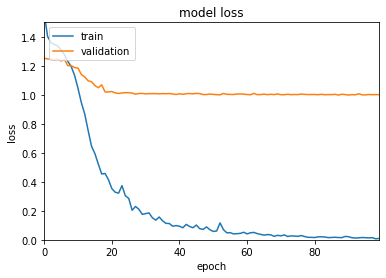

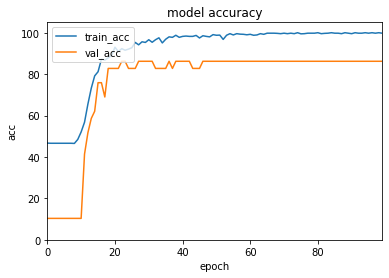

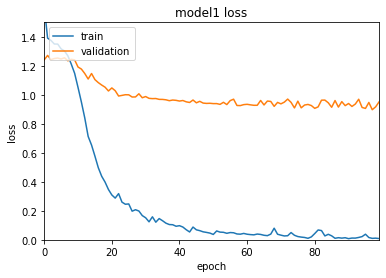

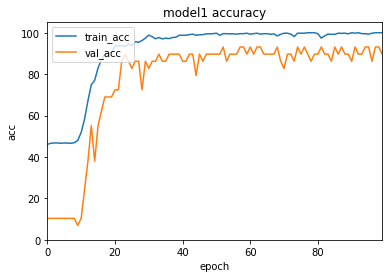

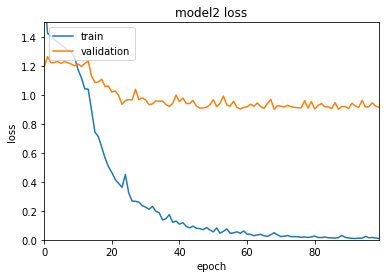

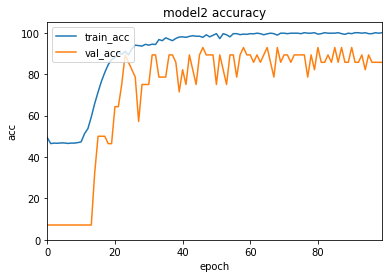

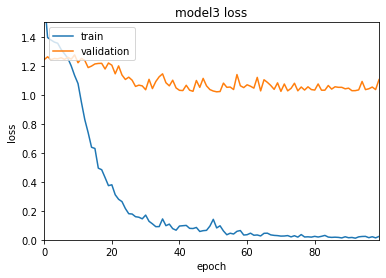

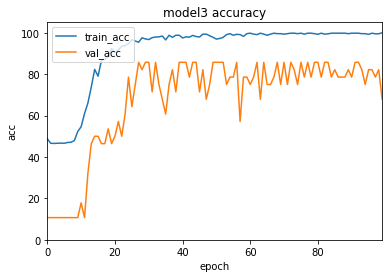

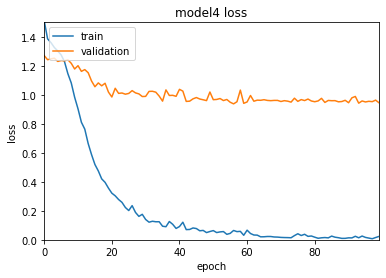

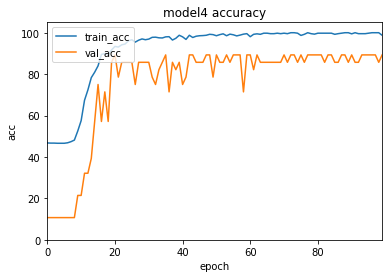

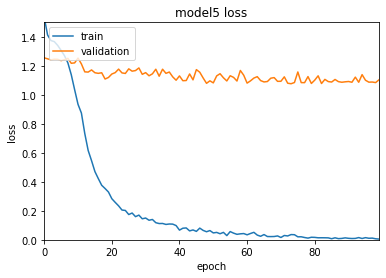

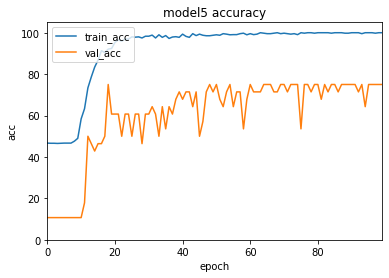

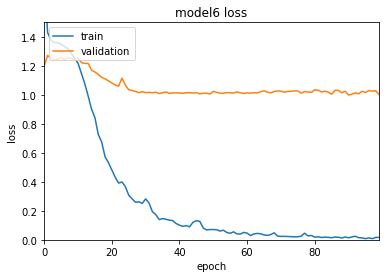

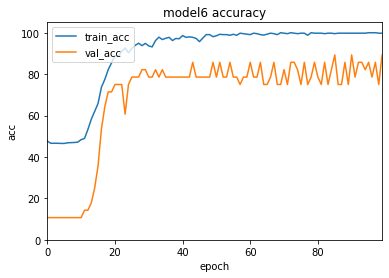

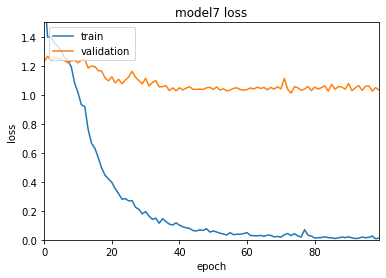

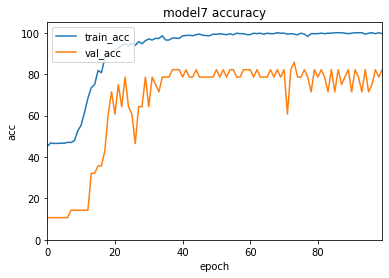

In [24]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss1)
plt.plot(val_loss1)
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc1)
plt.plot(val_acc1)
plt.title('model1 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss2)
plt.plot(val_loss2)
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc2)
plt.plot(val_acc2)
plt.title('model2 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss3)
plt.plot(val_loss3)
plt.title('model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc3)
plt.plot(val_acc3)
plt.title('model3 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss4)
plt.plot(val_loss4)
plt.title('model4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc4)
plt.plot(val_acc4)
plt.title('model4 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss5)
plt.plot(val_loss5)
plt.title('model5 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc5)
plt.plot(val_acc5)
plt.title('model5 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss6)
plt.plot(val_loss6)
plt.title('model6 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc6)
plt.plot(val_acc6)
plt.title('model6 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss7)
plt.plot(val_loss7)
plt.title('model7 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc7)
plt.plot(val_acc7)
plt.title('model7 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  86.20689655172413  PPV |  [0.89285714 0.        ]  Recall |  [0.96153846 0.        ]


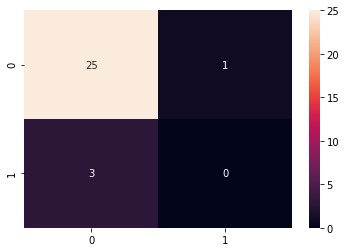

In [25]:
final_prediction = []
final_prediction_true = []

y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_0, y_pred_list)
ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_0, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_0:
    final_prediction_true.append(y)

Validation Accuracy |  89.65517241379311  PPV |  [0.89655172 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


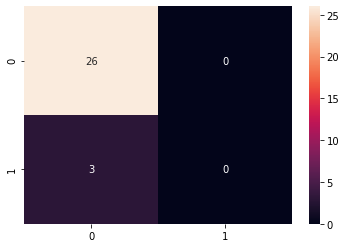

In [26]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data1, batch_size=1)
model1.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_1, y_pred_list)
ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_1, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_1:
    final_prediction_true.append(y)

Validation Accuracy |  85.71428571428571  PPV |  [0.92307692 0.        ]  Recall |  [0.92307692 0.        ]


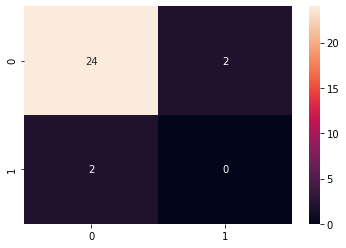

In [27]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data2, batch_size=1)
model2.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_2, y_pred_list)
ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_2, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_2:
    final_prediction_true.append(y)

Validation Accuracy |  67.85714285714286  PPV |  [0.86363636 0.        ]  Recall |  [0.76 0.  ]


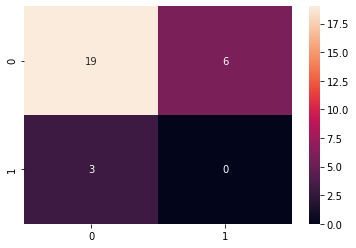

In [28]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data3, batch_size=1)
model3.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model3(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_3, y_pred_list)
ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_3, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_3:
    final_prediction_true.append(y)

Validation Accuracy |  89.28571428571429  PPV |  [0.92307692 0.5       ]  Recall |  [0.96       0.33333333]


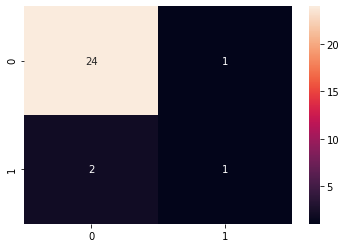

In [29]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data4, batch_size=1)
model4.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model4(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_4, y_pred_list)
ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_4, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_4:
    final_prediction_true.append(y)

Validation Accuracy |  75.0  PPV |  [0.875 0.   ]  Recall |  [0.84 0.  ]


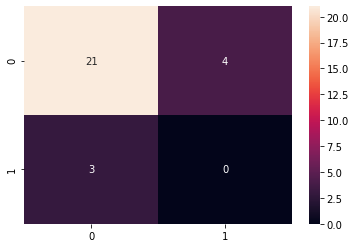

In [30]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data5, batch_size=1)
model5.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model5(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_5, y_pred_list)
ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_5, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_5:
    final_prediction_true.append(y)

Validation Accuracy |  89.28571428571429  PPV |  [0.89285714 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


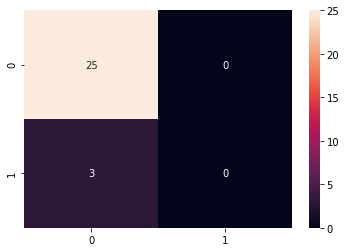

In [31]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data6, batch_size=1)
model6.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model6(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_6, y_pred_list)
ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_6, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_6:
    final_prediction_true.append(y)

Validation Accuracy |  82.14285714285714  PPV |  [0.88461538 0.        ]  Recall |  [0.92 0.  ]


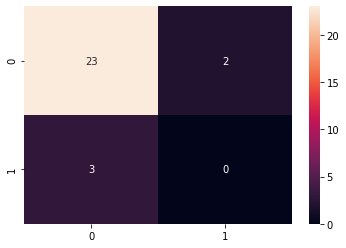

In [32]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data7, batch_size=1)
model7.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model7(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_7, y_pred_list)
ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_7, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_7:
    final_prediction_true.append(y)

In [33]:
prediction_labels = []
true_labels = []

for x in range(0,len(final_prediction_true)):
    true_labels.append(final_prediction_true[x][0])
    prediction_labels.append(final_prediction[x][0][0])

prediction_labels

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0

[[187  16]
 [ 22   1]]
Positive Predictive Value tp/(tp+fp):  0.058823529411764705
Accuracy Value (tp+tn)/(tp+fp+fn+tn):  0.831858407079646
Recall Value tp/(tp+fn):  0.043478260869565216


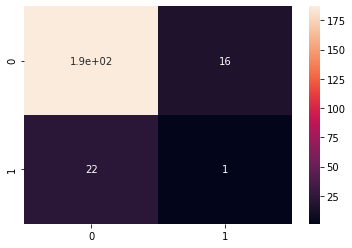

In [34]:
cf_matrix = confusion_matrix(true_labels, prediction_labels)
print(cf_matrix)
sn.heatmap(cf_matrix, annot=True)


accuracy = accuracy_score(true_labels, prediction_labels)
recall = recall_score(true_labels, prediction_labels, average=None)
prec_score = precision_score(true_labels, prediction_labels, average=None)
print('Positive Predictive Value tp/(tp+fp): ',prec_score[1]) 
print('Accuracy Value (tp+tn)/(tp+fp+fn+tn): ',accuracy) 
print('Recall Value tp/(tp+fn): ',recall[1]) 